In [2]:
from simulation import Simulation
from maker import SimpleMarketMaker, OrderType
from typing import List, Tuple, Literal

from data_maker import DataMarketMaker, run_mm, run_mm_plus, plot_defaults, plot

import numpy as np

In [2]:
class ExampleDataMarketMaker(DataMarketMaker):
    def update(self, prev_bid_price, prev_ask_price, holding, money, timestamp):
        return prev_bid_price, 0, prev_ask_price, 0, OrderType.new_limit_order(timestamp, timestamp + 100)

In [3]:
data = run_mm_plus(ExampleDataMarketMaker())

Running
Total profit: 0.0
Total holding: 0 at price 100.27218627929688 for a total of 0.0
Total cash: 10000
Final Revenue: 10000.0
Game completed in 0.6847074031829834 seconds


In [80]:
class SimpleStrategy_VolumeTrack(DataMarketMaker):
    def __init__(self):
        self.counter = False
        self.lamda = 0.1 # How close to the middle
        
        self.prev_bid_history = []
        self.prev_ask_history = []
        
        self.prev_mm_bid_price_history = []
        self.prev_mm_ask_price_history = []
        self.prev_mm_bid_amt_history = []
        self.prev_mm_ask_amt_history = []
        self.prev_holding_history = []
        self.prev_money_history = []
        
        self.tracker.config_info(["MM Bid Volume Filled", "MM Ask Volume Filled"]) # Allow tracker to recognize data points
        
    
    def update(self, prev_bid_price, prev_ask_price, holding, money, timestamp):
        
        self.prev_bid_history.append(prev_bid_price)
        self.prev_ask_history.append(prev_ask_price)
        self.prev_money_history.append(money)
        self.prev_holding_history.append(holding)
        
        if len(self.prev_bid_history) <= 1:
            """
            no prev amt history

            Currently implementing naive split spread strategy
            Buy at halfway between previous bid and midpoint
            Sell at halfway between midpoint and previous ask
            """
            p_diff = prev_ask_price - prev_bid_price
            
            eps = 0.01 * (prev_ask_price - prev_bid_price)
        
            middle = (prev_bid_price + prev_ask_price)/2
        
            cur_bid =  self.lamda * middle + (1 - self.lamda) * prev_bid_price + eps
            cur_ask = self.lamda * middle + (1 - self.lamda) * prev_ask_price + eps

            self.prev_mm_bid_price_history.append(cur_bid)
            self.prev_mm_ask_price_history.append(cur_ask)

            self.prev_mm_bid_amt_history.append(10)
            self.prev_mm_ask_amt_history.append(0)

            """trying to do it on a quicker limit order time scale
            same amount scale for now"""
            self.tracker.update_info(0, 0) # Keep track of info
            return cur_bid, 10,cur_ask, 0,OrderType.new_limit_order(timestamp, timestamp)
        
        diff_money = money - self.prev_money_history[-1]
        diff_hold = holding - self.prev_holding_history[-1]
        mm_prev_bid_price = self.prev_mm_bid_price_history[-1]
        mm_prev_ask_price = self.prev_mm_ask_price_history[-1]

        prev_bid_amt = self.prev_mm_bid_amt_history[-1]
        prev_ask_amt = self.prev_mm_ask_amt_history[-1]

        prev_bid_filled = (diff_money - mm_prev_ask_price * diff_hold) / (prev_ask_price - prev_bid_price)
        prev_ask_filled = (diff_money - mm_prev_bid_price * diff_hold) / (prev_ask_price - prev_bid_price) 
    
        self.tracker.update_info(prev_bid_filled, prev_ask_filled) # Keep track of info
        
        eps = 0.01 * (prev_ask_price - prev_bid_price)
        
        middle = (prev_bid_price + prev_ask_price)/2
        new_bid = self.lamda * middle + (1 - self.lamda) * prev_bid_price + eps
        new_ask = self.lamda * middle + (1 - self.lamda) * prev_ask_price + eps
        
        self.prev_mm_bid_price_history.append(new_bid)
        self.prev_mm_ask_price_history.append(new_ask)
        
        self.prev_mm_bid_amt_history.append(10)
        self.prev_mm_ask_amt_history.append(10)
        
        if not self.counter: 
            self.counter = True
            return new_bid, 50, new_ask, 0, OrderType.new_limit_order(timestamp, timestamp)
        
       
        
        return new_bid, 10, new_ask, 10, OrderType.new_limit_order(timestamp, timestamp)

In [62]:
strat = SimpleStrategy_VolumeTrack()

strat.prev_bid_history

[]

In [81]:
data = run_mm_plus(SimpleStrategy_VolumeTrack())
data

Running
Total profit: -60.02433776855469
Total holding: 0 at price 109.70938110351562 for a total of 0.0
Total cash: 9939.975662231445
Final Revenue: 9939.975662231445
Game completed in 1.6767621040344238 seconds


,Market Bid Price,Market Ask Price,Holding,Money,Bid Price,Bid Vol,Ask Price,Ask Vol,MM Bid Volume Filled,MM Ask Volume Filled
Timestamp,,,,,,,,,,
0,99.500000,100.500000,0,10000.000000,99.560000,10,100.460000,0,0.0,0.0
1,100.000153,100.074188,10,8999.258118,100.004595,50,100.071227,0,0.0,0.0
2,99.912735,100.072723,60,3995.621948,99.922334,10,100.066324,10,0.0,0.0
3,99.771347,99.982086,70,2995.801086,99.783991,10,99.973657,10,0.0,0.0
4,99.468147,99.678246,60,3990.482559,99.480753,10,99.669842,10,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
23395,109.952995,110.129066,0,9939.975662,109.963560,10,110.122024,10,0.0,0.0
23396,109.935402,110.121353,0,9939.975662,109.946559,10,110.113915,10,0.0,0.0
23397,109.523209,109.765518,0,9939.975662,109.537747,10,109.755826,10,0.0,0.0


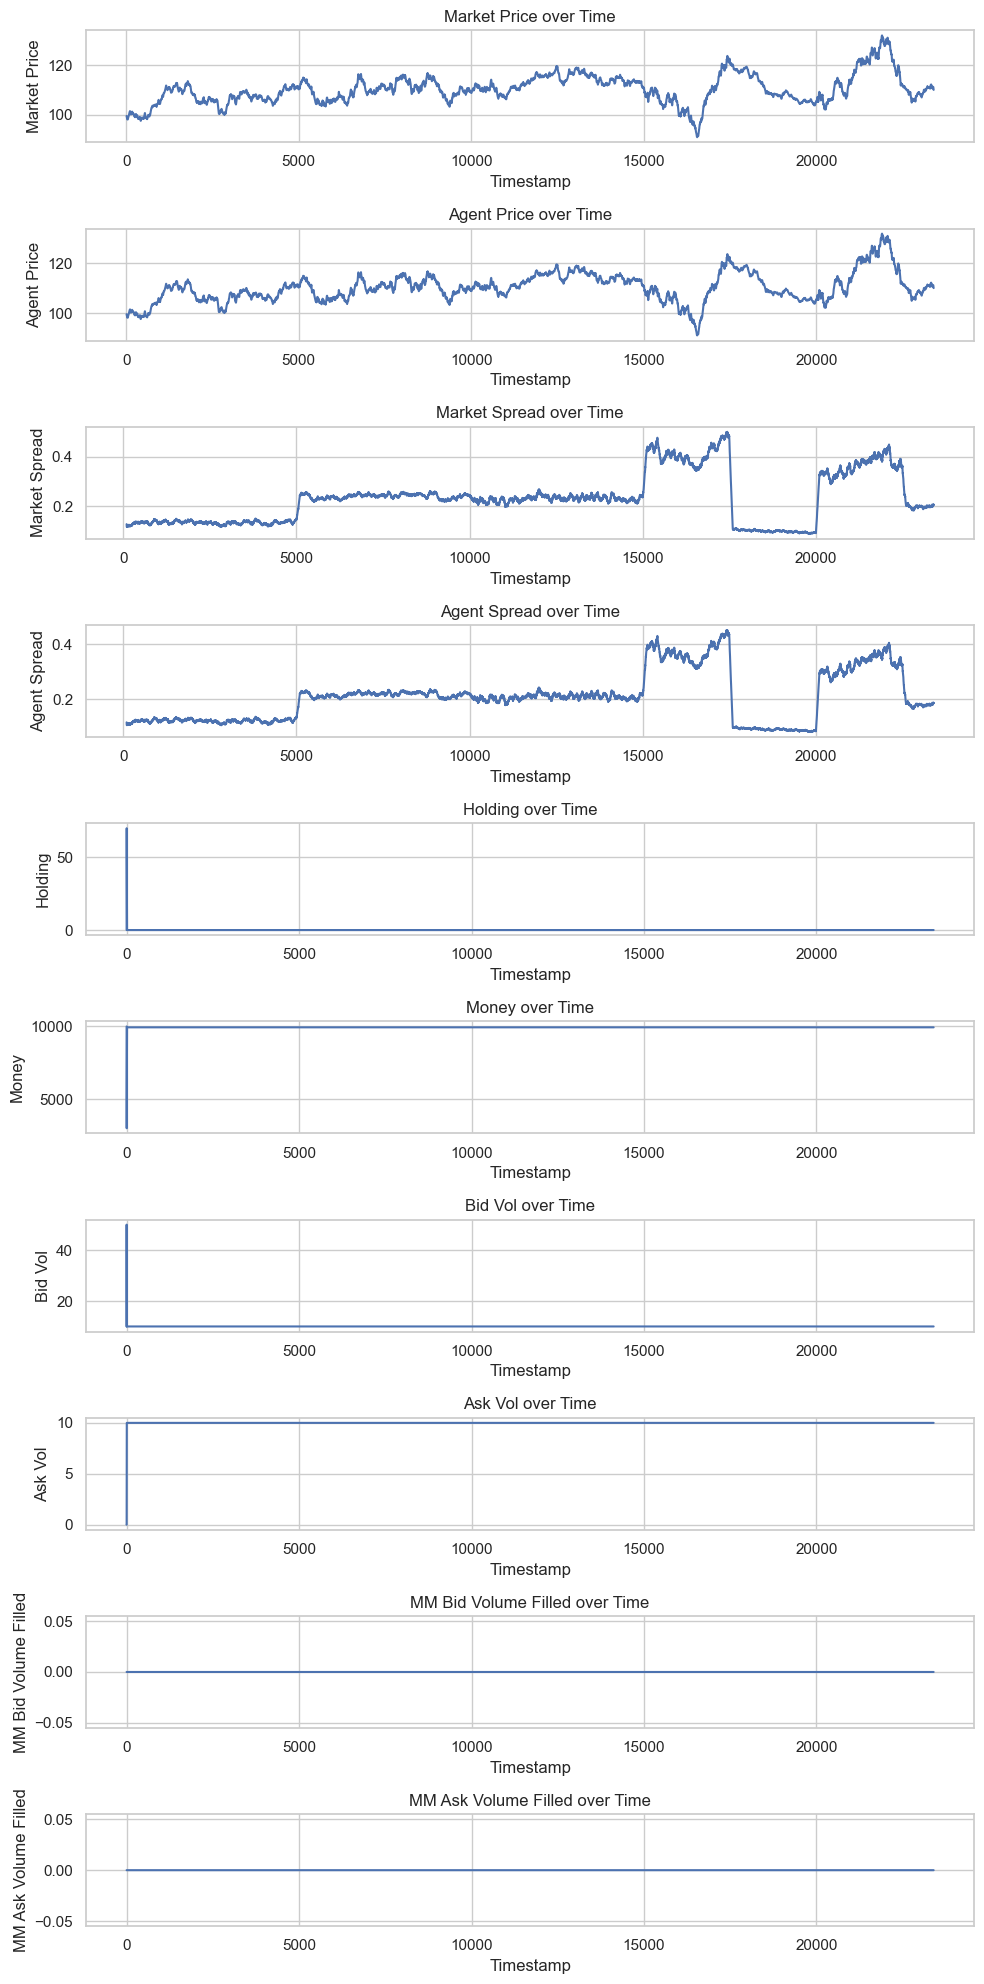

In [82]:
plot_defaults(data, additional_cols = ["MM Bid Volume Filled", "MM Ask Volume Filled"])

In [45]:
class SimpleStrategy(DataMarketMaker):
    def __init__(self):
        self.counter = False
        self.lamda = 0.1 # How close to the middle
    
    def update(self, prev_bid_price, prev_ask_price, holding, money, timestamp):
        
        eps = 0.01 * (prev_ask_price - prev_bid_price)
        
        middle = (prev_bid_price + prev_ask_price)/2
        new_bid = self.lamda * middle + (1 - self.lamda) * prev_bid_price + eps
        new_ask = self.lamda * middle + (1 - self.lamda) * prev_ask_price + eps
        self.tracker.update_info(mean, std) # Keep track of info
        
        if not self.counter: 
            self.counter = True
            return new_bid, 50, new_ask, 0, OrderType.new_limit_order(timestamp, timestamp + 1)
        
        return new_bid, 10, new_ask, 10, OrderType.new_limit_order(timestamp, timestamp + 1)

In [46]:
data = run_mm_plus(SimpleStrategy())
data

Running
Total profit: -8502.748390197754
Total holding: 4 at price 104.23785400390625 for a total of 416.951416015625
Total cash: 1080.300193786621
Final Revenue: 1497.251609802246
Game completed in 1.791975736618042 seconds


,Market Bid Price,Market Ask Price,Holding,Money,Bid Price,Bid Vol,Ask Price,Ask Vol
Timestamp,,,,,,,,
0,99.500000,100.500000,0,10000.000000,99.560000,50,100.460000,0
1,99.929741,100.057739,50,4997.113037,99.937421,10,100.052619,10
2,99.734192,99.901878,40,5994.454956,99.744253,10,99.895171,10
3,99.619423,99.702141,30,6990.649185,99.624386,10,99.698832,10
4,99.727051,99.876747,40,5991.881714,99.736033,10,99.870759,10
...,...,...,...,...,...,...,...,...
23395,104.511917,104.634270,0,1503.635582,104.519258,10,104.629376,10
23396,104.083649,104.332703,0,1503.635582,104.098592,10,104.322740,10
23397,104.158798,104.392365,10,459.711937,104.172812,10,104.383022,10


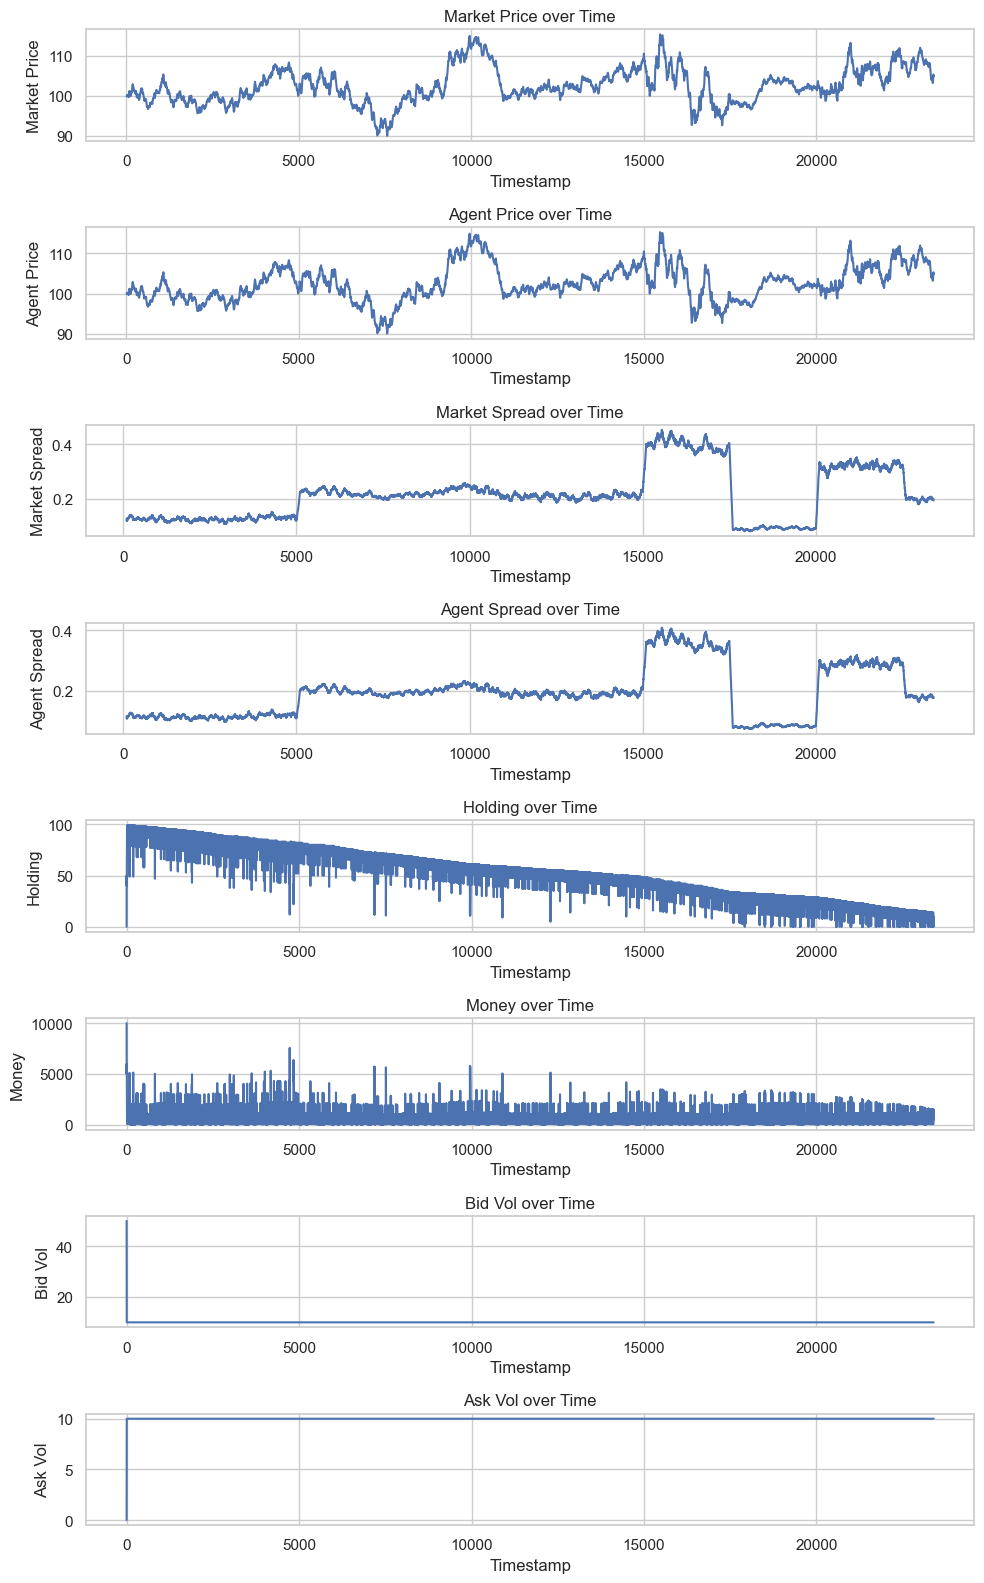

In [47]:
plot_defaults(data)

In [12]:
class BadStrategy(DataMarketMaker):
        """
        An example on how to implement a market maker.
        """
        def __init__(self):
            self.prev_bid_history = []
            self.prev_ask_history = []
            
            self.window = 5
            self.simulations = 10
            self.sim_horizon = 1
            
            self.tracker.config_info(["Simulated Price", "Simulated Std"]) # Allow tracker to recognize data points
       
        def update(self, prev_bid_price, prev_ask_price, holding, money, timestamp) -> Tuple[float, int, float, int, OrderType]:
                        
            self.prev_bid_history.append(prev_bid_price)
            self.prev_ask_history.append(prev_ask_price)
            
            mean, std = self.simulate()
            self.tracker.update_info(mean, std) # Keep track of info
            
            buy_dev = std * -0.1
            sell_dev = std * 0.1
            
            max_buy_price = prev_bid_price + buy_dev
            max_sell_price = prev_ask_price + sell_dev
            
            order = OrderType.new_limit_order(timestamp, timestamp + 1)
            return max_buy_price, int(money/max_buy_price - 1) // 2, max_sell_price, holding//2, order
        
        def simulate(self):    
            price_history = (np.array(self.prev_bid_history[-self.window:]) + np.array(self.prev_ask_history[-self.window:])) / 2
            diffs = np.diff(np.log(price_history[-self.window:]))

            if len(self.prev_bid_history) < self.window:
                avg_orig_price = (self.prev_bid_history[-1] + self.prev_ask_history[-1])/2
                return avg_orig_price, np.std(price_history)
            
            std = np.std(diffs) ** 2
            drift = np.mean(diffs) + std ** 2 / 2

            future_prices = []
            for _ in range(self.simulations): 
                future_prices.append(price_history[-1] * np.exp(np.sum(np.random.normal(drift, std, self.sim_horizon))))

            future_prices = np.array(future_prices)

            return np.mean(future_prices), np.std(future_prices)

In [13]:
strat = BadStrategy()
data = run_mm_plus(strat)

Running


NameError: name 'money' is not defined

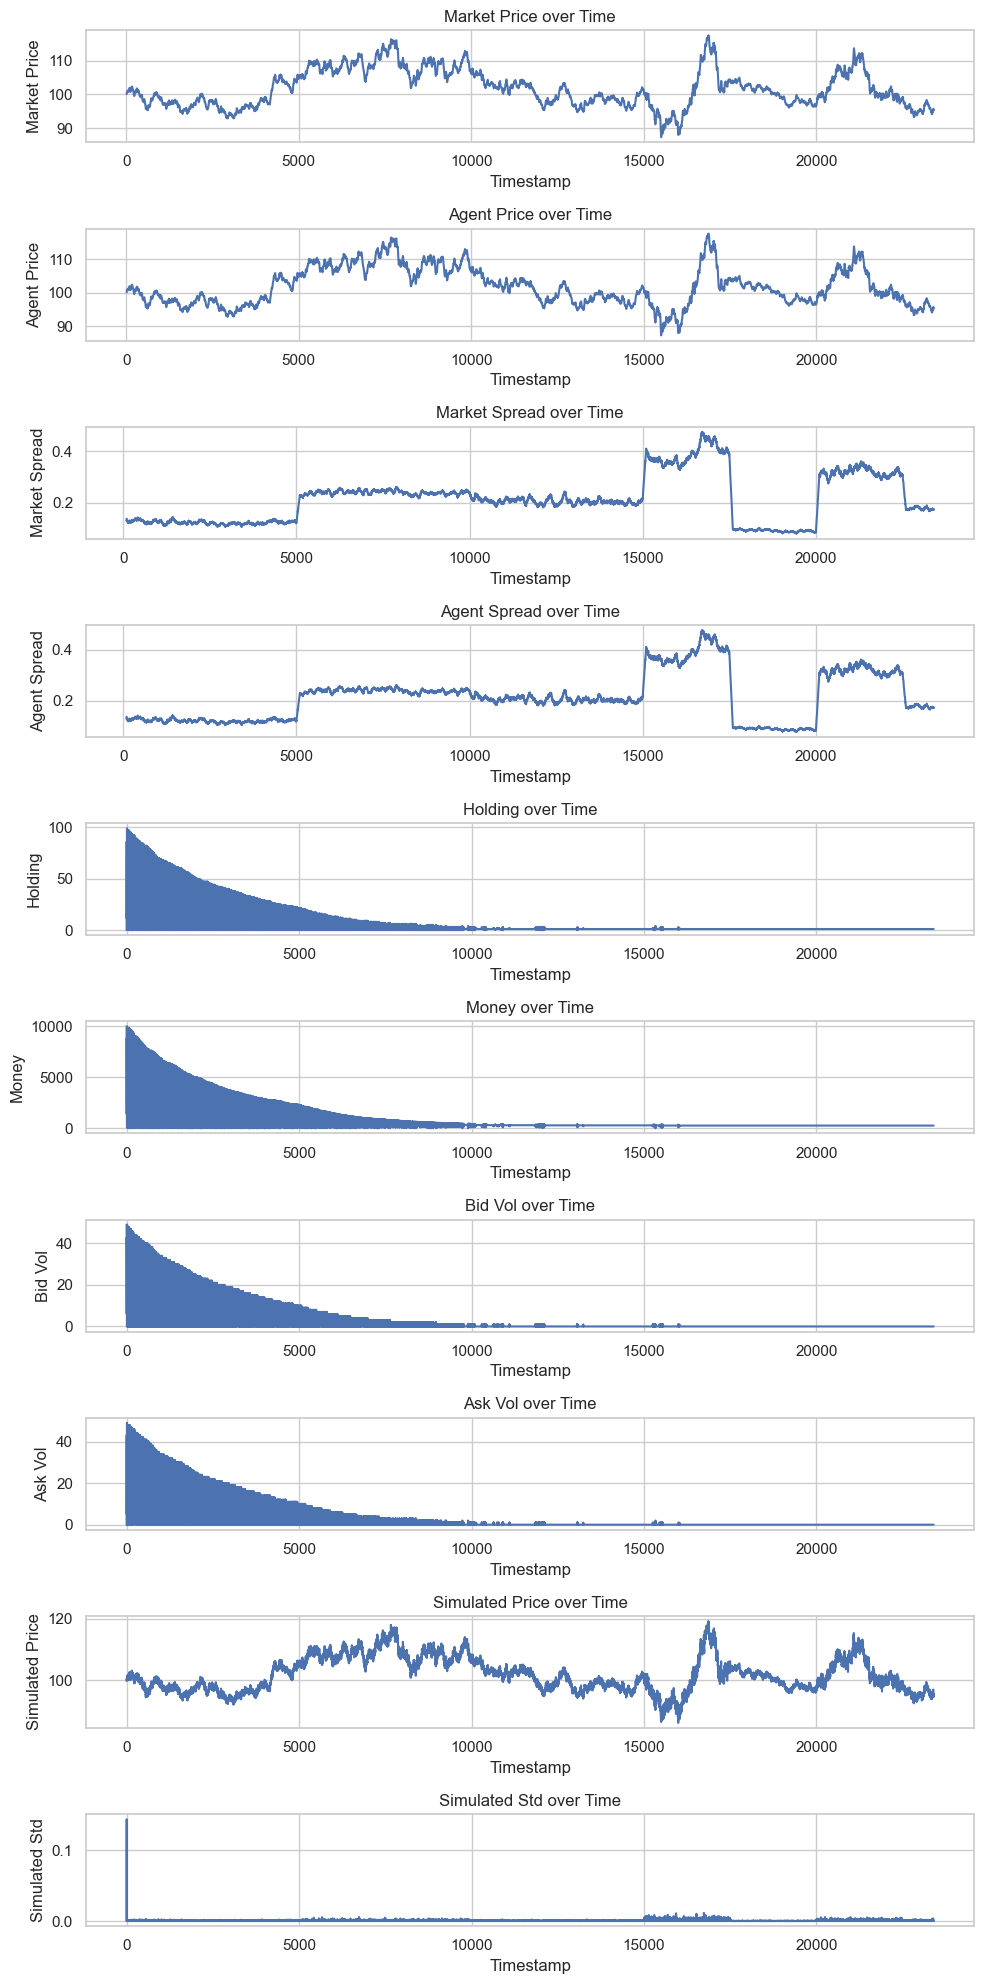

In [33]:
plot_defaults(data, additional_cols = ["Simulated Price", "Simulated Std"])

In [5]:
data["Price"] = (data["Market Bid Price"] + data["Market Ask Price"]) / 2
data

,Market Bid Price,Market Ask Price,Holding,Money,Bid Price,Bid Vol,Ask Price,Ask Vol,Simulated Price,Simulated Std,Price
Timestamp,,,,,,,,,,,
0,99.500000,100.500000,0,10000.000000,99.500000,49,100.500000,0,100.000000,0.000000,100.000000
1,100.048012,100.132088,49,5093.527702,100.043509,24,100.136590,24,100.090050,0.045025,100.090050
2,100.109856,100.306267,73,2686.177299,100.101336,12,100.314786,36,100.208061,0.085196,100.208061
3,100.239426,100.336700,85,1482.136894,100.228417,6,100.347709,42,100.288063,0.110089,100.288063
4,100.426750,100.523209,91,878.997643,100.426748,3,100.523210,45,100.594062,0.000017,100.474979
...,...,...,...,...,...,...,...,...,...,...,...
23395,103.120834,103.471008,1,265.695480,103.120787,0,103.471056,0,103.115532,0.000475,103.295921
23396,103.311821,103.528999,1,265.695480,103.311763,0,103.529058,0,103.331978,0.000584,103.420410
23397,103.367599,103.508278,1,265.695480,103.367544,0,103.508334,0,103.412085,0.000560,103.437939


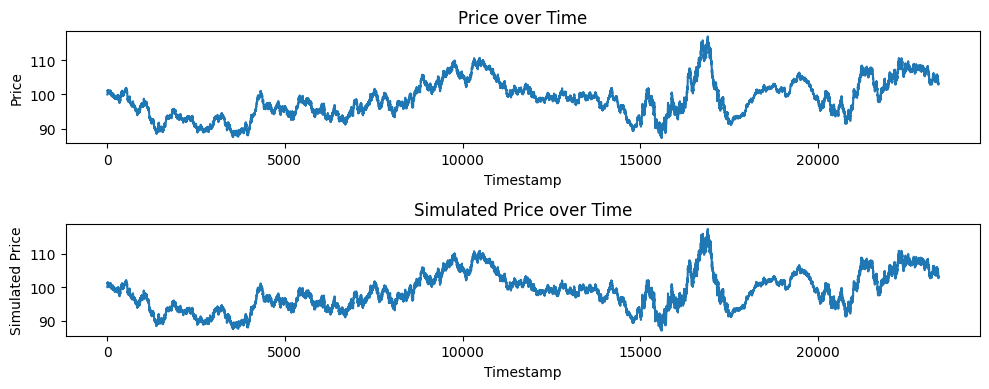

In [6]:
plot(data, ["Price", "Simulated Price"])

In [7]:
price = data["Price"]
sim_price = data["Simulated Price"]

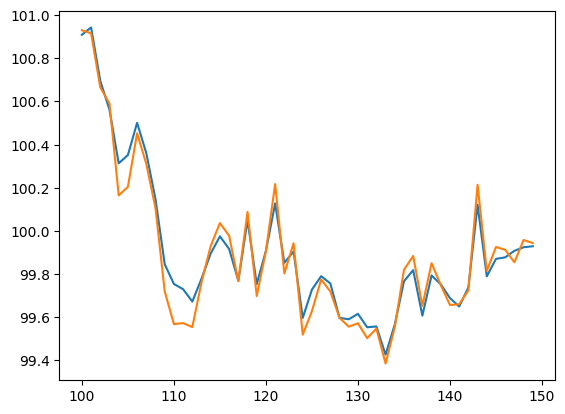

In [9]:
import matplotlib.pyplot as plt
n = 100
x = 50

plt.plot(price[n:n+x])
plt.plot(sim_price[n:n+x])

In [50]:
window = 10
simulations = 1
sim_horizon = 3

def simulate(price_history): 
    diffs = np.diff(np.log(price_history[-window:]))

    std = np.std(diffs) ** 2
    drift = np.mean(diffs) + std ** 2 / 2

    future = []
    for _ in range(simulations): 
        future.append(np.cumsum(np.random.normal(drift, std, sim_horizon)))

    print(future)
        
    future_prices_estimates = price_history[-1] * np.exp(np.sum(np.array(future)))
    
    print(future_prices_estimates)

    return np.mean(future_prices_estimates), np.std(future_prices_estimates)    

In [72]:
window = 10
simulations = 10
sim_horizon = 3

def simulate(price_history):
    diffs = np.diff(np.log(price_history[-window:]))

    std = np.std(diffs) ** 2
    drift = np.mean(diffs) + std ** 2 / 2

    future_prices = []
    for _ in range(simulations): 
        future_prices.append(price_history[-1] * np.exp(np.sum(np.random.normal(drift, std, sim_horizon))))

    future_prices = np.array(future_prices)

    return np.mean(future_prices), np.std(future_prices)
    
simulate(price_history)

(123.96845013378679, 0.013261002619424348)

In [73]:
price_history = np.random.normal(100, 0.5, 20) + np.cumsum(np.random.normal(1, 0.5, 20))
print(price_history)

sims = []
for i in range(2, 20):
    sims.append(simulate(price_history[:i])[0])

[101.47002925 101.81376542 103.37621128 104.80720366 104.81012248
 104.9324695  107.67671021 107.03816628 108.02639648 110.66733967
 111.38425555 112.75392303 112.69755344 113.77086767 115.00252329
 115.07202616 116.27880259 117.62302833 118.86601243 118.34030758]


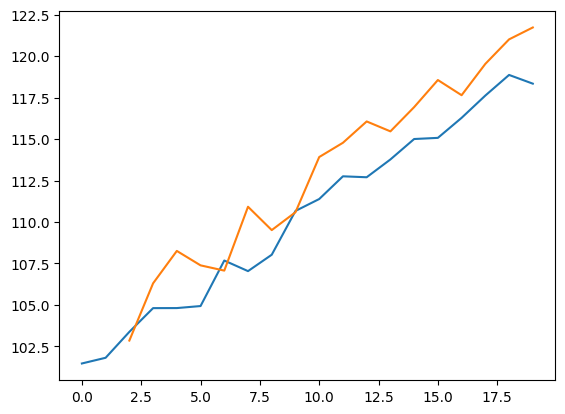

In [76]:
plt.plot(np.arange(20), price_history)
plt.plot(np.arange(2, 20), sims)